# `Module 8`: Recurrent Neural Networks

### Problem Statement:

* Build a sentiment analysis model using Recurrent Neural Networks (RNNs) to classify movie reviews from the IMDB dataset into positive or negative sentiments.

* The dataset comprises 25,000 movie reviews from IMDB, labeled by sentiment (positive/negative). 
* Reviews have been preprocessed, and each review is encoded as a sequence of word indices (integers). 
* The words in the dataset are indexed by overall frequency in the dataset, allowing for quick filtering operations such as:
    * "only consider the top 10,000 most common words, but eliminate the top 20 most common words".

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import re
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

from transformers import BertModel, BertTokenizer

import torch
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn as nn

### download pre-trained BERT model

In [2]:
bert_model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

### import datasets

In [6]:
df = pd.read_csv("dataset/IMDB_dataset/Train.csv")
df.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [7]:
df = df.iloc[:100]
df.shape

(100, 2)

In [8]:
df.label.value_counts()

label
0    52
1    48
Name: count, dtype: int64

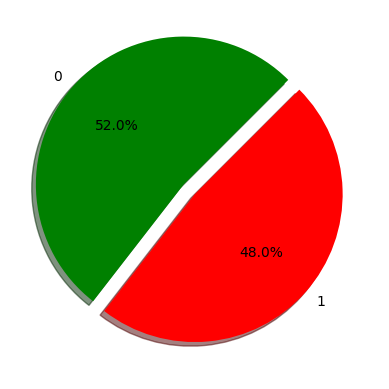

In [9]:
color = ["Green", "Red"]
df.label.value_counts().plot(kind="pie", autopct='%.1f%%', shadow=True, colors=color, explode=(0.1, 0), startangle=45)
plt.ylabel(None)
plt.show()

### data cleaning

In [10]:
nltk.download('stopwords')
stop_word = set(stopwords.words("english"))
emoji_pattern = re.compile(r'(?::|;|=)(?:-)?(?:\)|\(|D|P)')
peter = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bhaut\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
# cleaning text
def cleanText(str_):
    str_ = re.sub(r'<[^>]*>', '', str_)
    emojis = emoji_pattern.findall(str_)
    str_ = re.sub('[^a-z0-9]+', " ", str_.lower()) + ' '.join(emojis).replace('-', '')

    text = [peter.stem(word) for word in str_.split() if word not in stop_word]
    
    return " ".join(text)

In [12]:
df.text = df.text.apply(cleanText)
df.head()

,text,label
0,grew b 1965 watch love thunderbird mate school...,0
1,put movi dvd player sat coke chip expect hope ...,0
2,peopl know particular time past like feel need...,0
3,even though great interest biblic movi bore de...,0
4,im die hard dad armi fan noth ever chang got t...,1


### Embedding 

In [13]:
texts = df.text.to_list()

In [14]:
def getEmbedding(texts):
    
    embedding = []
    batch_size = 8
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i : i + batch_size]
        input = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=512)

        with torch.no_grad():
            output = bert_model(**input)

        batch_embeddings = output.last_hidden_state.mean(dim=1)
        embedding.append(batch_embeddings)
    
    return torch.cat(embedding, dim=0) # Concatenate all batch embeddings

In [15]:
x = getEmbedding(texts)

In [ ]:
y = torch.tensor(df.label.values, dtype=torch.float32)

### Custom dataset for torch based

In [ ]:
class IMDBDataset(Dataset):
    def __init__(self, text, label):
        self.text = text
        self.label = label

    def __len__(self):
        return len(self.text)

    def __getitem__(self, idx):
        return self.text[idx], self.label[idx]

In [ ]:
dataset = IMDBDataset(x, y)

In [ ]:
len(dataset)

In [ ]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_data, test_data = random_split(dataset, [train_size, test_size])

In [ ]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=True)

### create RNN model

In [ ]:
input_size = x.shape[1]

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, input_size):
        super(RNNModel, self).__init__()
        
        self.rnn = nn.RNN(input_size, 32, batch_first=True)
        self.fc = nn.Linear(32, 1) # if 2 classes so enter 1
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.unsqueeze(1) # Adding sequence dimension
        _, h = self.rnn(x)
        x = self.fc(h.squeeze(0))
        x = self.sigmoid(x)
        return x

In [ ]:
model = RNNModel(input_size)
print(model)

### train model

In [ ]:
lr = 0.001
epoch_size = 20

In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
model.train()
for epoch in range(epoch_size):
    
    total_loss = 0
    for text, lab in train_loader:
        pred_lab = model(text).squeeze()

        optimizer.zero_grad()
        loss = criterion(pred_lab, lab.float())
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch: {epoch+1}/{epoch_size} loss: {total_loss:0.4f}")

In [ ]:
model.eval()
with torch.no_grad():
    
    correct = 0
    total = 0
    for input, target in test_loader:

        output = model(input).squeeze()
        pred_target = (output > 0.5).float()
        correct += (pred_target == target).sum().item()
        total += input.size(0)
    
    print(f"Model Accuracy is {correct/total*100:.2f}%")